# Objectives {.unnumbered}

By the end of this lab, you will:
1. Load and analyze the **Lightcast dataset** in **Spark DataFrame**.
2. Create **five easy and three medium-complexity visualizations** using **Plotly**.
3. Explore **salary distributions, employment trends, and job postings**.
4. Analyze **skills in relation to NAICS/SOC/ONET codes and salaries**.
5. Customize **colors, fonts, and styles** in all visualizations (**default themes result in a 2.5-point deduction**).
6. Follow **best practices for reporting on data communication**.

# Step 1: Load the Dataset {.unnumbered}


In [11]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import re
import plotly.graph_objects as go

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("./data/lightcast_job_postings.csv")

# Show Schema and Sample Data
df.printSchema()
df.show(5)

root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATION_LEVELS_NAME: string (nullable = true)
 |-- MIN_EDULEVELS: integer (

# Salary Distribution by Employment Type
- Identify salary trends across different employment types.
- **Filter the dataset**
  - Remove records where **salary is missing or zero**.
- **Aggregate Data**
  - Group by **employment type** and compute salary distribution.
- **Visualize results**
  - Create a **box plot** where:
    - **X-axis** = `EMPLOYMENT_TYPE_NAME`
    - **Y-axis** = `SALARY_FROM`
  - Customize **colors, fonts, and styles** to avoid a **2.5-point deduction**.
- **Explanation:** Write two sentences about what the graph reveals.



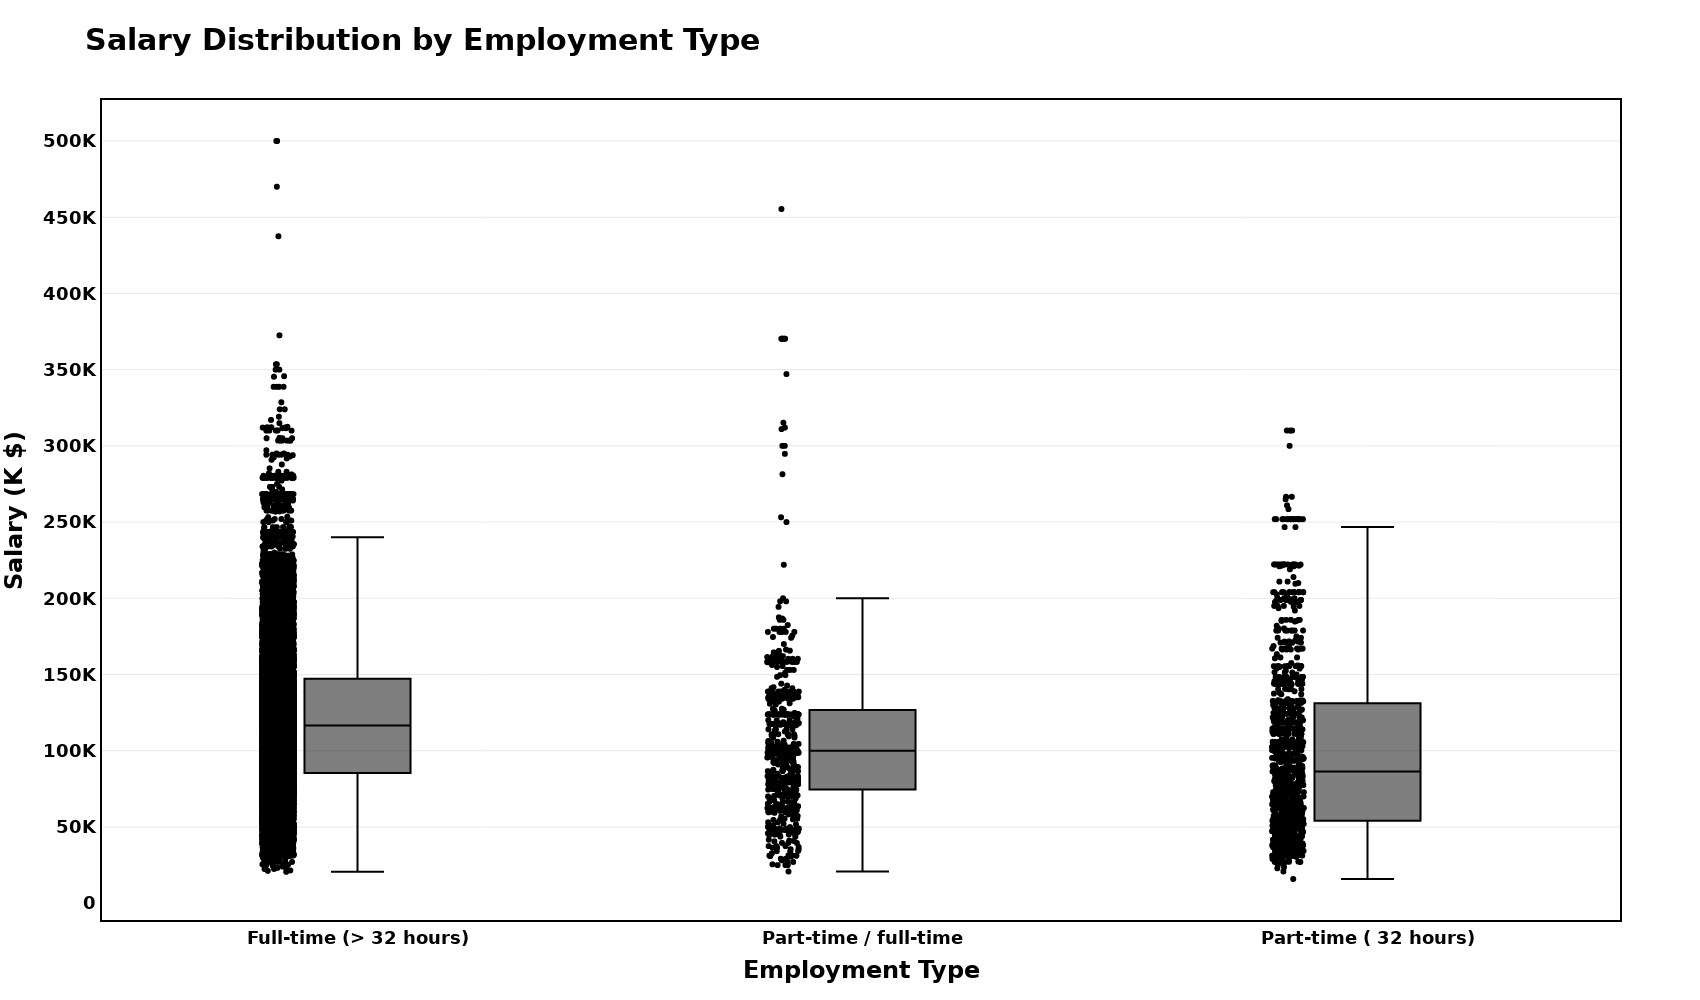

In [3]:
# Your Code for 1st question here

# Filter out missing or zero salary values
pdf = df.filter(df["SALARY"] > 0).select("EMPLOYMENT_TYPE_NAME", "SALARY").toPandas()

# Clean employment type names for better readability
pdf["EMPLOYMENT_TYPE_NAME"] = pdf["EMPLOYMENT_TYPE_NAME"].apply(lambda x: re.sub(r"[^\x00-\x7F]+", "", x))

# Compute median salary for sorting
median_salaries = pdf.groupby("EMPLOYMENT_TYPE_NAME")["SALARY"].median()

# Sort employment types based on median salary in descending order
sorted_employment_types = median_salaries.sort_values(ascending=False).index

# Apply sorted categories
pdf["EMPLOYMENT_TYPE_NAME"] = pd.Categorical(
    pdf["EMPLOYMENT_TYPE_NAME"], 
    categories=sorted_employment_types, 
    ordered=True
)

# Create box plot with horizontal grid lines
fig = px.box(
    pdf, 
    x="EMPLOYMENT_TYPE_NAME", 
    y="SALARY", 
    title="Salary Distribution by Employment Type", 
    color_discrete_sequence=["black"],  # Single neutral color
    boxmode="group",
    points="all",  # Show all outliers
)

# Improve layout, font styles, and axis labels
fig.update_layout(
    title=dict(
        text="Salary Distribution by Employment Type", 
        font=dict(size=30, family="Arial", color="black", weight="bold")  # Bigger & Bold Title
    ),
    xaxis=dict(
        title=dict(text="Employment Type", font=dict(size=24, family="Arial", color="black", weight="bold")),  # Bigger X-label
        tickangle=0,  # Rotate X-axis labels for readability
        tickfont=dict(size=18, family="Arial", color="black", weight="bold"),  # Bigger & Bold X-ticks
        showline=True,  # Show axis lines
        linewidth=2,  # Thicker axis lines
        linecolor="black",
        mirror=True,
        showgrid=False,  # Remove vertical grid lines
        categoryorder="array",  
        categoryarray=sorted_employment_types.tolist()
    ),
    yaxis=dict(
        title=dict(text="Salary (K $)", font=dict(size=24, family="Arial", color="black", weight="bold")),  # Bigger Y-label
        tickvals=[0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000],
        ticktext=["0", "50K", "100K", "150K", "200K", "250K", "300K", "350K", "400K", "450K", "500K"],
        tickfont=dict(size=18, family="Arial", color="black", weight="bold"),  # Bigger & Bold Y-ticks
        showline=True,  
        linewidth=2,  
        linecolor="black",
        mirror=True,  
        showgrid=True,  # Enable light horizontal grid lines
        gridcolor="lightgray",  # Light shade for the horizontal grid
        gridwidth=0.5  # Thin grid lines
    ),
    font=dict(family="Arial", size=16, color="black"),
    boxgap=0.7,  
    plot_bgcolor="white",
    paper_bgcolor="white",
    showlegend=False,  
    height=1000,  
    width=1700,  
)

# Show the figure
fig.show()


**Salary Distribution:** *Full-time employees working more than 32 hours have a higher median salary compared to part-time and mixed employment types, indicating better earning potential for full-time roles.*

**Variability in Salaries:** *The full-time category has a wider spread of salaries and a higher concentration of outliers, suggesting greater variability in earnings, possibly due to differences in experience, job roles, or industries.*

**Outliers and Salary Extremes:** *All employment types have salary outliers, but full-time employees exhibit the highest number of extreme salaries, indicating that while most employees earn within a standard range, a few earn significantly higher wages.*

# Salary Distribution by Industry
- Compare salary variations across industries.
- **Filter the dataset**
  - Keep records where **salary is greater than zero**.
- **Aggregate Data**
  - Group by **NAICS industry codes**.
- **Visualize results**
  - Create a **box plot** where:
    - **X-axis** = `NAICS2_NAME`
    - **Y-axis** = `SALARY_FROM`
  - Customize colors, fonts, and styles.
- **Explanation:** Write two sentences about what the graph reveals.

**Industry Salary Variation:** *The Information (Info) and Accommodation & Food industries have the highest median salaries, while Educational Services (Edu. Services) and Agriculture & Fish show the lowest median salaries.This suggests that jobs in tech and hospitality industries tend to offer higher pay compared to education and agriculture sectors.*

**Outliers in Salaries:** *Some industries, such as Information, Professional & Scientific Services, and Mining & Oil, have significant salary outliers, indicating that a few jobs within these sectors offer extremely high salaries compared to the median.*

**Salary Distribution Trends:** *The middle 50% salary range (interquartile range, IQR) is wider in high-paying industries, indicating a broader variation in salaries. Conversely, industries with lower median salaries tend to have a narrower IQR, suggesting more consistent pay within those fields.*

# Job Posting Trends Over Time
- Analyze how job postings fluctuate over time.
- **Aggregate Data**
  - Count job postings per **posted date (`POSTED`)**.
- **Visualize results**
  - Create a **line chart** where:
    - **X-axis** = `POSTED`
    - **Y-axis** = `Number of Job Postings`
  - Apply custom colors and font styles.
- **Explanation:** Write two sentences about what the graph reveals.

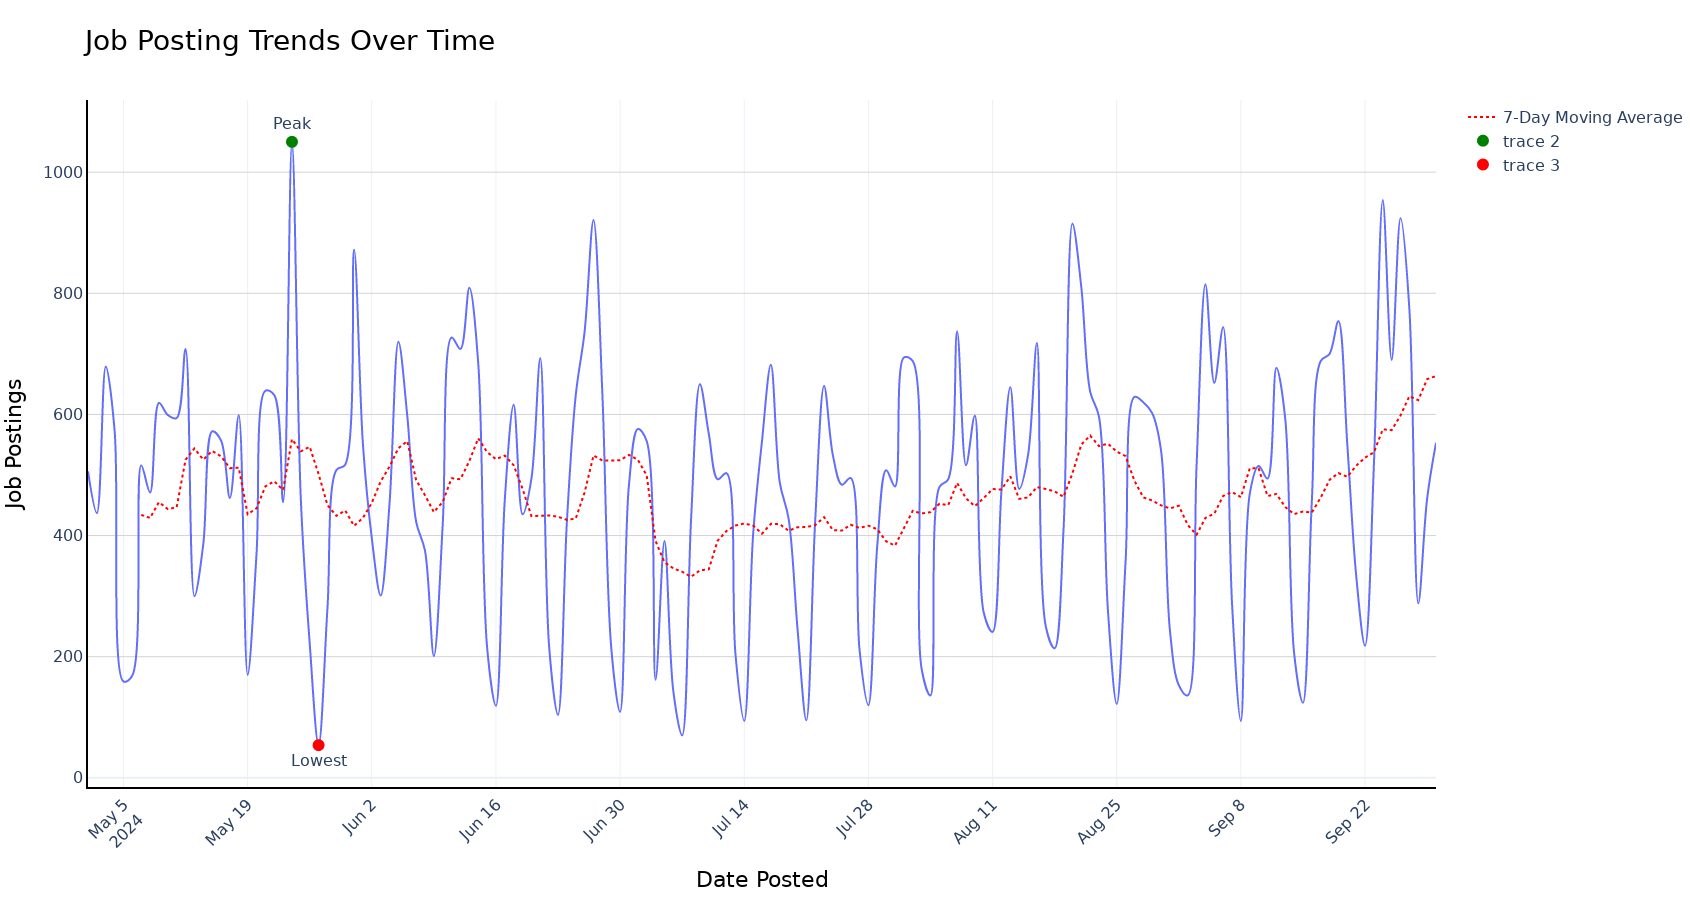

In [ ]:
# Your Code for 2st question here

# Load Data (Ensure df is pre-loaded with "POSTED" and "Number of Job Postings")
pdf = df.select("POSTED").toPandas()

# Convert POSTED to DateTime format for proper ordering
pdf["POSTED"] = pd.to_datetime(pdf["POSTED"])

# Aggregate the number of job postings per date
job_trend = pdf.groupby("POSTED").size().reset_index(name="Number of Job Postings")

# Compute a 7-day rolling average for trend smoothing
job_trend["7-Day Moving Avg"] = job_trend["Number of Job Postings"].rolling(window=7).mean()

# Create the line chart
fig = px.line(
    job_trend, 
    x="POSTED", 
    y="Number of Job Postings",
    title="Job Posting Trends Over Time",
    labels={"POSTED": "Date Posted", "Number of Job Postings": "Job Postings"},
    width=1700,
    height=900,
    line_shape="spline",
)

# Add the 7-day rolling average trend line
fig.add_trace(
    go.Scatter(
        x=job_trend["POSTED"], 
        y=job_trend["7-Day Moving Avg"], 
        mode="lines", 
        name="7-Day Moving Average",
        line=dict(color="red", width=2, dash="dot")  # Dashed red line for better contrast
    )
)

# Highlight key points (e.g., max and min job postings)
max_point = job_trend.loc[job_trend["Number of Job Postings"].idxmax()]
min_point = job_trend.loc[job_trend["Number of Job Postings"].idxmin()]

fig.add_trace(
    go.Scatter(
        x=[max_point["POSTED"]], 
        y=[max_point["Number of Job Postings"]], 
        mode="markers+text",
        text="Peak",
        textposition="top center",
        marker=dict(color="green", size=12)
    )
)

fig.add_trace(
    go.Scatter(
        x=[min_point["POSTED"]], 
        y=[min_point["Number of Job Postings"]], 
        mode="markers+text",
        text="Lowest",
        textposition="bottom center",
        marker=dict(color="red", size=12)
    )
)

# Improve layout with a light theme and contrasting colors
fig.update_layout(
    template="plotly_white",
    font=dict(family="Arial", size=16),  # Global font size
    title=dict(text="Job Posting Trends Over Time", font=dict(size=28, family="Arial", color="black")),  # Bigger title
    xaxis=dict(
        title=dict(text="Date Posted", font=dict(size=22, family="Arial", color="black")),  # Bigger X-axis title
        showline=True,
        linewidth=2,
        linecolor="black",
        tickangle=-45
    ),
    yaxis=dict(
        title=dict(text="Job Postings", font=dict(size=22, family="Arial", color="black")),  # Bigger Y-axis title
        showline=True,
        linewidth=2,
        linecolor="black",
        gridcolor="lightgray"
    ),
    plot_bgcolor="white",
)

# Show the plot
fig.show()

**Seasonal Fluctuations** – *The job postings show a cyclical pattern, with frequent peaks and dips. For example, postings range between a low of approximately 50 (June 2) and a high of over 1,050 (June 13), indicating weekly or periodic hiring surges.*

**Upward Trend in Postings** – *The 7-day moving average (dashed red line) shows a general increase in job postings over time. Early in the timeline (May), the average postings were around 450–500, while towards late September, the average steadily increased to 600+, suggesting growing job demand over time.*

**Significant Peaks and Dips** – *The highest job posting count was recorded on June 13, exceeding 1,050 postings, while the lowest dip occurred on June 2, with fewer than 50 postings. These extreme variations may be due to major hiring events, policy changes, or external economic factors.*

# Top 10 Job Titles by Count
- Identify the most frequently posted job titles.
- **Aggregate Data**
  - Count the occurrences of each **job title (`TITLE_NAME`)**.
  - Select the **top 10 most frequent titles**.
- **Visualize results**
  - Create a **bar chart** where:
    - **X-axis** = `TITLE_NAME`
    - **Y-axis** = `Job Count`
  - Apply custom colors and font styles.
- **Explanation:** Write two sentences about what the graph reveals.

In [7]:
# Your code for 4th question here

# Remote vs On-Site Job Postings
- Compare the proportion of remote and on-site job postings.
- **Aggregate Data**
  - Count job postings by **remote type (`REMOTE_TYPE_NAME`)**.
- **Visualize results**
  - Create a **pie chart** where:
    - **Labels** = `REMOTE_TYPE_NAME`
    - **Values** = `Job Count`
  - Apply custom colors and font styles.
- **Explanation:** Write two sentences about what the graph reveals.

In [8]:
# Your code for 5th question here

# Skill Demand Analysis by Industry (Stacked Bar Chart)
- Identify which skills are most in demand in various industries.
- **Aggregate Data**
  - Extract **skills** from job postings.
  - Count occurrences of skills grouped by **NAICS industry codes**.
- **Visualize results**
  - Create a **stacked bar chart** where:
    - **X-axis** = `Industry`
    - **Y-axis** = `Skill Count`
    - **Color** = `Skill`
  - Apply custom colors and font styles.
- **Explanation:** Write two sentences about what the graph reveals.

In [9]:
# Your code for 6th question here


# Salary Analysis by ONET Occupation Type (Bubble Chart)
- Analyze how salaries differ across ONET occupation types.
- **Aggregate Data**
  - Compute **median salary** for each occupation in the **ONET taxonomy**.
- **Visualize results**
  - Create a **bubble chart** where:
    - **X-axis** = `ONET_NAME`
    - **Y-axis** = `Median Salary`
    - **Size** = Number of job postings
  - Apply custom colors and font styles.
- **Explanation:** Write two sentences about what the graph reveals.

In [10]:
# Your code for 7th question here

# Career Pathway Trends (Sankey Diagram)
- Visualize job transitions between different occupation levels.
- **Aggregate Data**
  - Identify career transitions between **SOC job classifications**.
- **Visualize results**
  - Create a **Sankey diagram** where:
    - **Source** = `SOC_2021_2_NAME`
    - **Target** = `SOC_2021_3_NAME`
    - **Value** = Number of transitions
  - Apply custom colors and font styles.
- **Explanation:** Write two sentences about what the graph reveals.

In [11]:
# Your code for 8th question here